# Feature Extraction and Selection

In this notebook we used [tsfresh](https://tsfresh.readthedocs.io/) to extract useful features from the communication and
 social network app usage time series data, and uses them to train a logistic regression classifier for the anxiety
 prediction task.


In [1]:
# import necessary libraries/methods
import numpy as np

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

import seaborn as sns
import matplotlib.pylab as plt

from tsfresh import extract_features
from tsfresh.feature_extraction import MinimalFCParameters

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression

import shap

---
## Load in the data

In [2]:
PATH_TO_DATA = None

# load EMA data
df_ema = pd.read_csv(PATH_TO_DATA + "EMA_data.csv")
ema_cols = ["Age", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]

df_ema_enc = pd.read_csv(PATH_TO_DATA + "EMA_data_enc.csv")
ema_cols_enc = ["sc_age", "Sex", "Lives_Alone", "CurrentActivity", "Covid25", "Covid34", "Covid37", "Covid43"]

# load communication data and group by patient id
df_temp = pd.read_csv(PATH_TO_DATA + "temp_data.csv")
df_temp["date"] = pd.to_datetime(df_temp["date"], format = "%Y-%m-%d")

## Extract Features

We can use the data to extract time series features using `tsfresh`.
We want to extract features for each time series, that means for patient (which is our `id`) and for both the communication and social useage.

You can think of it like this: tsfresh will result in a single row for each `id` and will calculate the features for each columns (we call them "kind") separately.

The `date` column is our sorting column.
For an overview on the data formats of `tsfresh`, please have a look at [the documentation](https://tsfresh.readthedocs.io/en/latest/text/data_formats.html).

In [3]:
from IPython.display import Image

Image(url="https://github.com/blue-yonder/tsfresh/raw/main/docs/images/introduction_ts_exa_features.png")

In [4]:
# We are very explicit here and specify the `default_fc_parameters`.
# Have a look into the documentation (https://tsfresh.readthedocs.io/en/latest/text/feature_extraction_settings.html)
extraction_settings = MinimalFCParameters()

X = extract_features(df_temp[["user", "date", "comm_med", "social_med"]], column_id="user", column_sort="date",
                     default_fc_parameters=extraction_settings)

X.head()

Feature Extraction: 100%|██████████| 19/19 [00:02<00:00,  7.57it/s]


,comm_med__sum_values,comm_med__median,comm_med__mean,comm_med__length,comm_med__standard_deviation,comm_med__variance,comm_med__maximum,comm_med__minimum,social_med__sum_values,social_med__median,social_med__mean,social_med__length,social_med__standard_deviation,social_med__variance,social_med__maximum,social_med__minimum
1888,4.564,0.259,0.049,93.000,0.944,0.890,1.518,-4.738,-0.767,0.130,-0.008,93.000,0.747,0.558,1.238,-4.113
4170,-21.944,-0.238,-0.354,62.000,1.017,1.034,1.721,-3.588,27.370,0.563,0.441,62.000,0.741,0.549,1.900,-2.166
5995,-6.097,-0.157,-0.359,17.000,0.834,0.695,0.613,-3.085,-4.805,-0.343,-0.283,17.000,0.454,0.206,0.452,-1.406
6050,-94.558,-0.919,-1.017,93.000,0.574,0.329,0.171,-3.874,-18.697,-0.216,-0.201,93.000,0.522,0.273,1.446,-3.689
7053,52.391,0.622,0.609,86.000,0.621,0.386,1.704,-3.349,48.600,0.655,0.565,86.000,0.404,0.163,1.159,-0.896


## Train and evaluate classifier

We train a logistic regression model. To find the best hyper-parameter setting we use grid search.

In [5]:
X_ema = df_ema_enc[["user"]+ema_cols_enc].set_index("user")
X = pd.concat([X, X_ema], axis=1)
y = df_ema_enc[["user","Anxiety_Group"]].set_index("user")

param_grid = {
    "penalty" : ["l1", "l2"],
    "C" : np.logspace(-4, 4, 20),
    "class_weight" : ["balanced", None],
    "solver": ["liblinear", "saga"]
}

lg_clf = GridSearchCV(LogisticRegression(random_state=0, max_iter = 10000),
                      param_grid, cv=10, n_jobs=-1).fit(X.values, y.values.ravel())

# Select best classifier
best_clf = lg_clf.best_estimator_

print(best_clf)

LogisticRegression(C=0.03359818286283781, class_weight='balanced',
                   max_iter=10000, penalty='l1', random_state=0,
                   solver='liblinear')


## Cross-validation

We apply K-fold cross validation on the data. Typical values for k are k=3, k=5, and k=10, with 10 representing the most
 common value. This is because, given extensive testing, 10-fold cross-validation provides a good balance of low
 computational cost and low bias in the estimate of model performance as compared to other k values and a single
 train-test split. Therefore, we will preform 10-Fold CV.

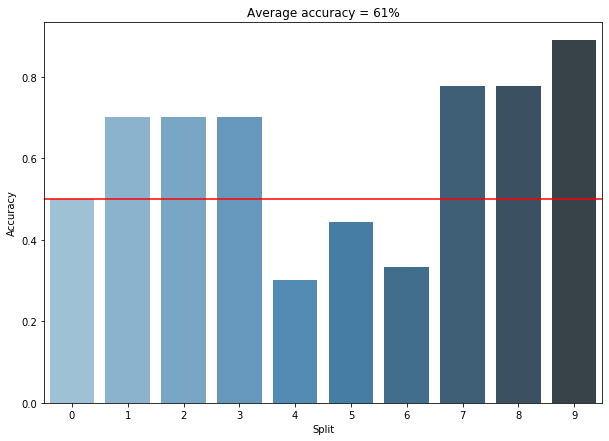

In [6]:
n_splits = 10
cv_acc = cross_val_score(best_clf, X.values, y.values.ravel(), cv=n_splits)

fig, ax = plt.subplots(1,1,figsize=(10,7))
sns.barplot(x="Split", y="Accuracy", data=pd.DataFrame({
    "Split" : np.arange(n_splits),
    "Accuracy": cv_acc
}), ax=ax, palette="Blues_d");

ax.axhline(y=.5, color="r");

ax.set_title("Average accuracy = {}%".format(int(np.mean(cv_acc)*100)));

## Feature importance analysis

This gives a simple example of explaining a linear logistic regression sentiment analysis model using shap. Note that with a linear model the SHAP value for feature i for the prediction  f(x)  (assuming feature independence) is just  ϕi=βi⋅(xi−E[xi]) . Since we are explaining a logistic regression model the units of the SHAP values will be in the log-odds space.

In [7]:
X_array = X.values        # we need to pass a dense version for the plotting functions
y_array = y.values.ravel()

explainer = shap.LinearExplainer(best_clf, X_array)
shap_values = explainer.shap_values(X_array)

### Summarise the effect of all the features

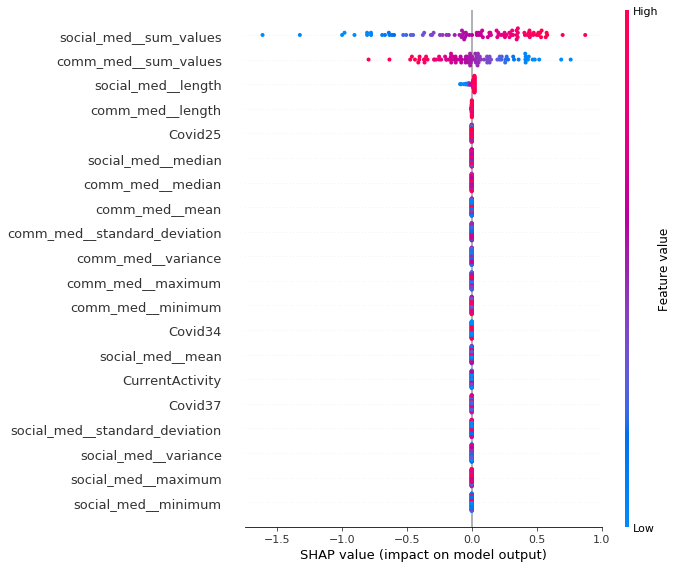

In [8]:
shap.summary_plot(shap_values, X_array, feature_names=X.columns)

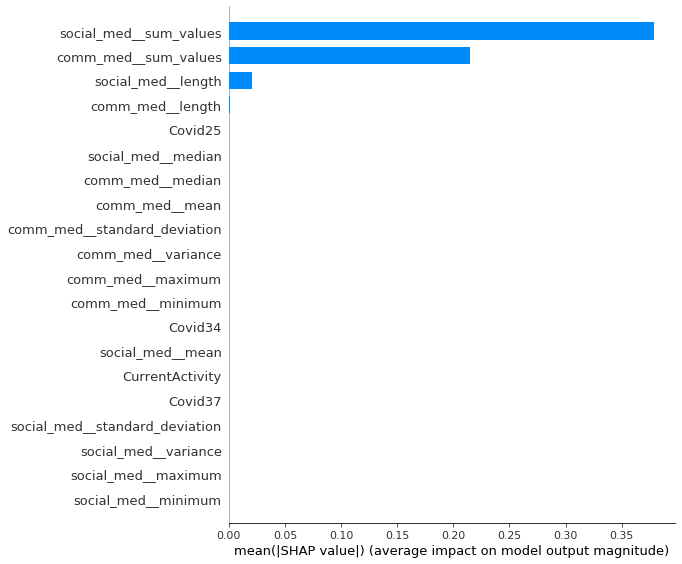

In [9]:
shap.summary_plot(shap_values, X_array, feature_names=X.columns, plot_type="bar")

### Explain the first patient"s anxiety prediction

Remember that higher means more likely to be label 0, hence "Clinical anxiety", so in the plots below the "red" features
 are actually helping raise the chance of a "Non-clinical anxiety" outcome, while the negative features are lowering the
 chance.

In [10]:
shap.initjs()

ind = 0
print("Non-clinical anxiety" if y_array[ind] else "Clinical anxiety")
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_array[ind,:],
    feature_names=X.columns
)

Clinical anxiety


### Explain the second patient"s anxiety prediction

In [11]:
shap.initjs()

ind = 1
print("Non-clinical anxiety" if y_array[ind] else "Clinical anxiety")

shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_array[ind,:],
    feature_names=X.columns
)


Non-clinical anxiety
